In [20]:
library(tidyverse)
library(caret)
library(lattice)
library(dygraphs)
library(cowplot)
library(ggthemr)

ggthemr::ggthemr("fresh")
options(repr.plot.width=12, repr.plot.height=5)

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

_Note: All EDA done on training split only_

## What value do the zones add?

### For regression

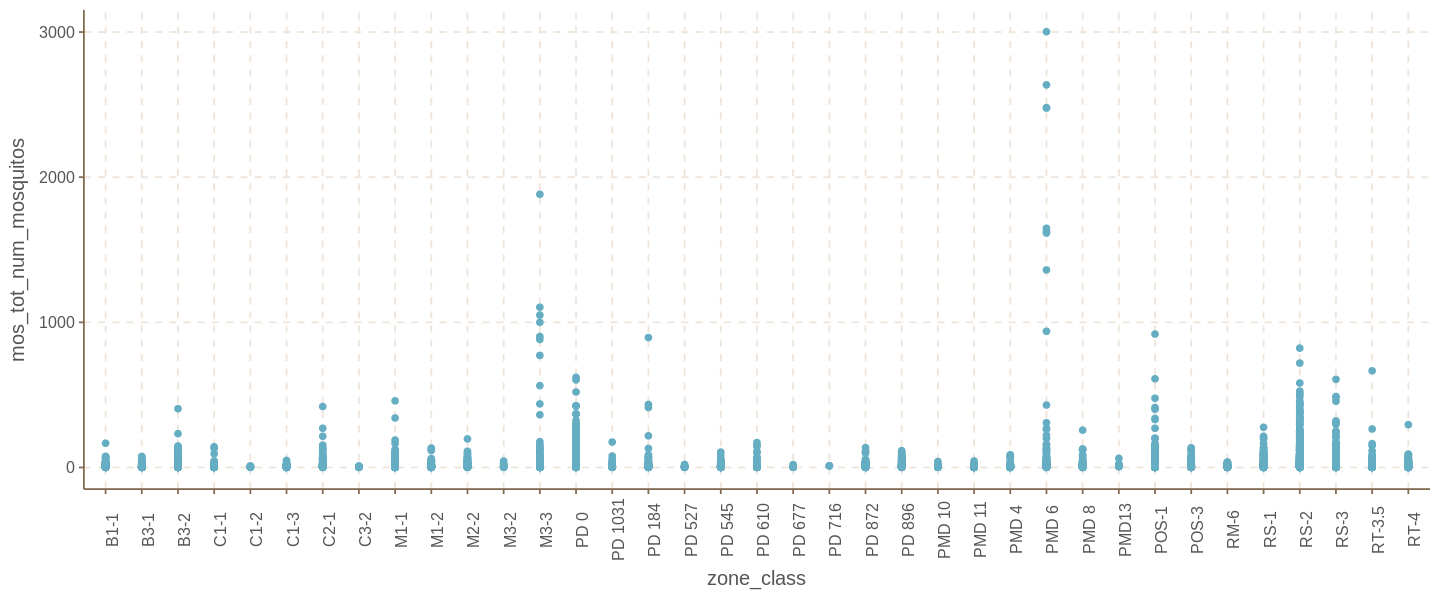

In [26]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=zone_class)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90))

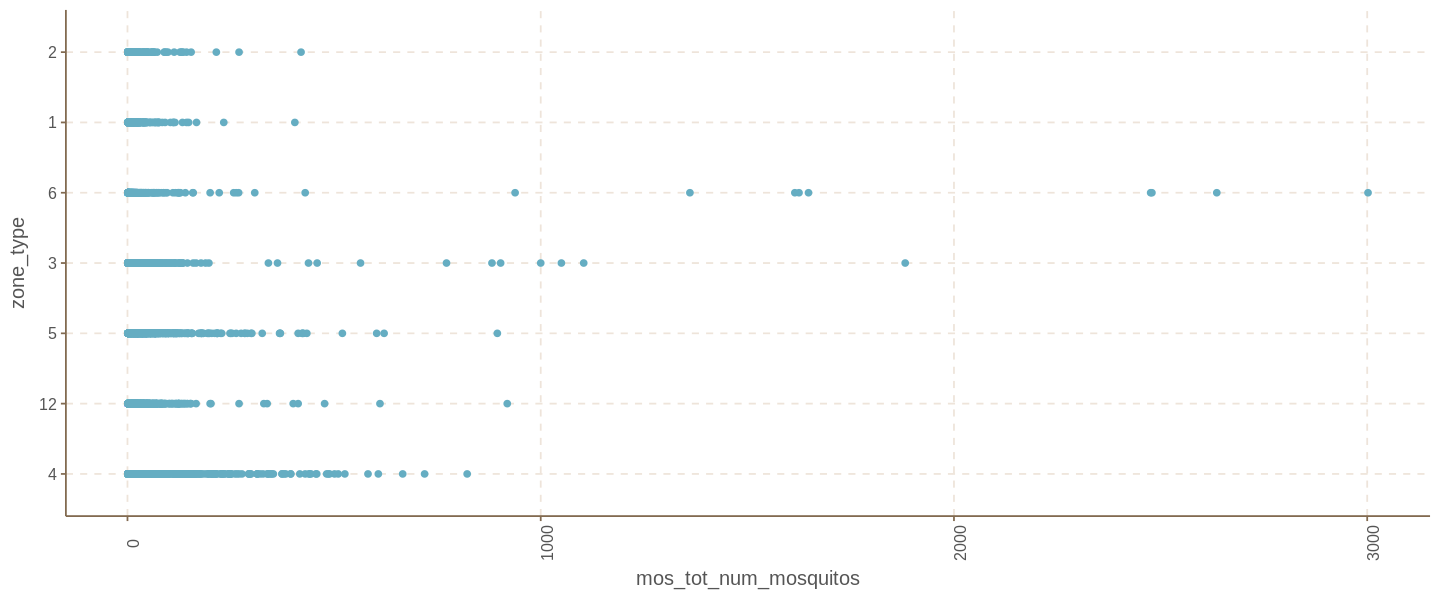

In [31]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=zone_type)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90))+coord_flip()

## For classification

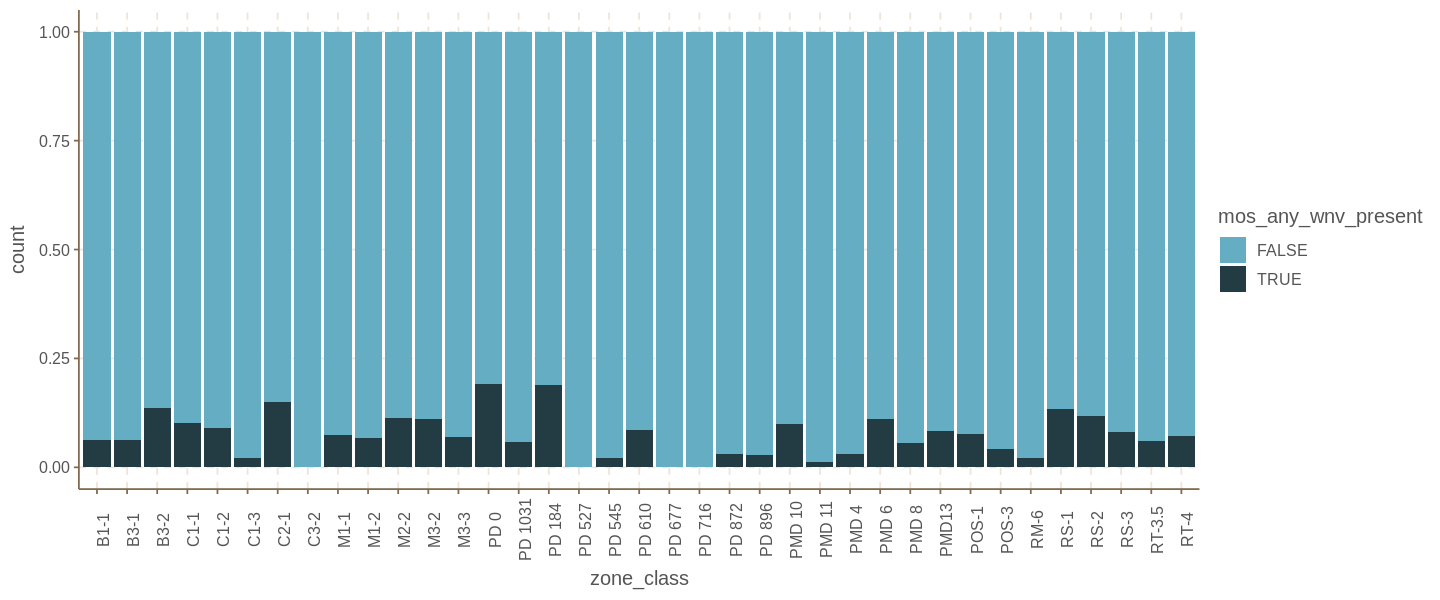

In [28]:
df_train %>% ggplot(aes(fill=mos_any_wnv_present,zone_class)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))

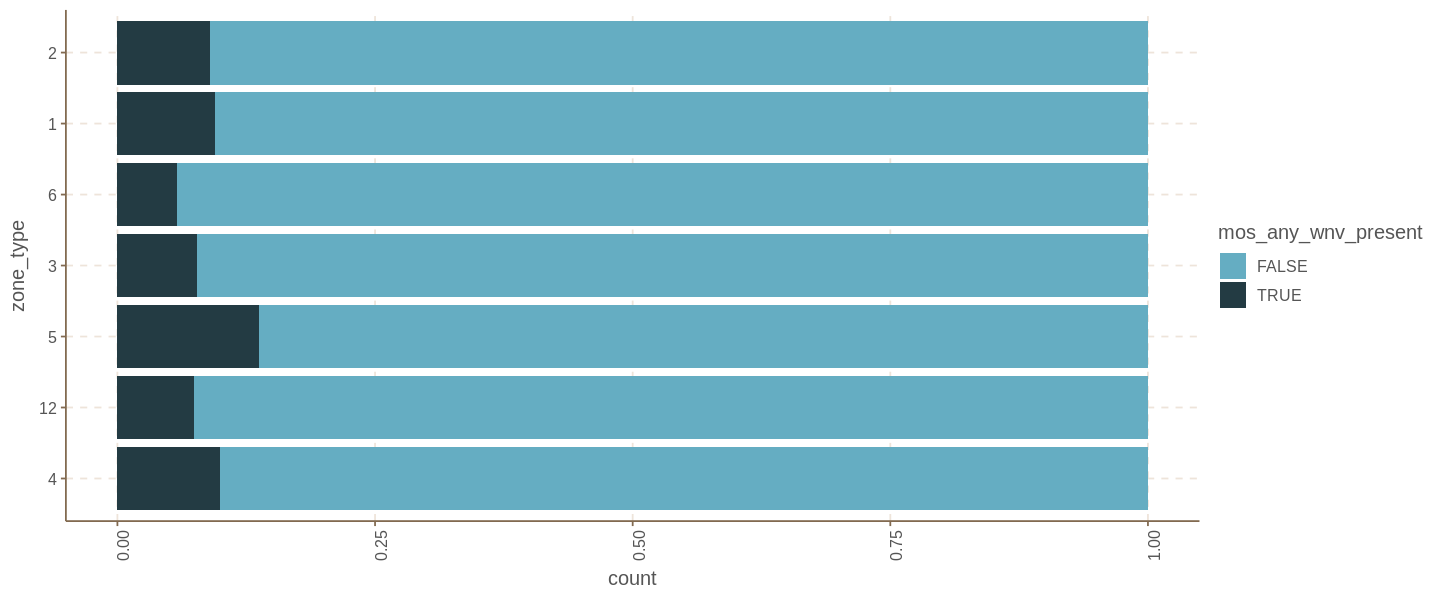

In [30]:
df_train %>% ggplot(aes(fill=mos_any_wnv_present,zone_type)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))+coord_flip()

### Where are the different zones located?

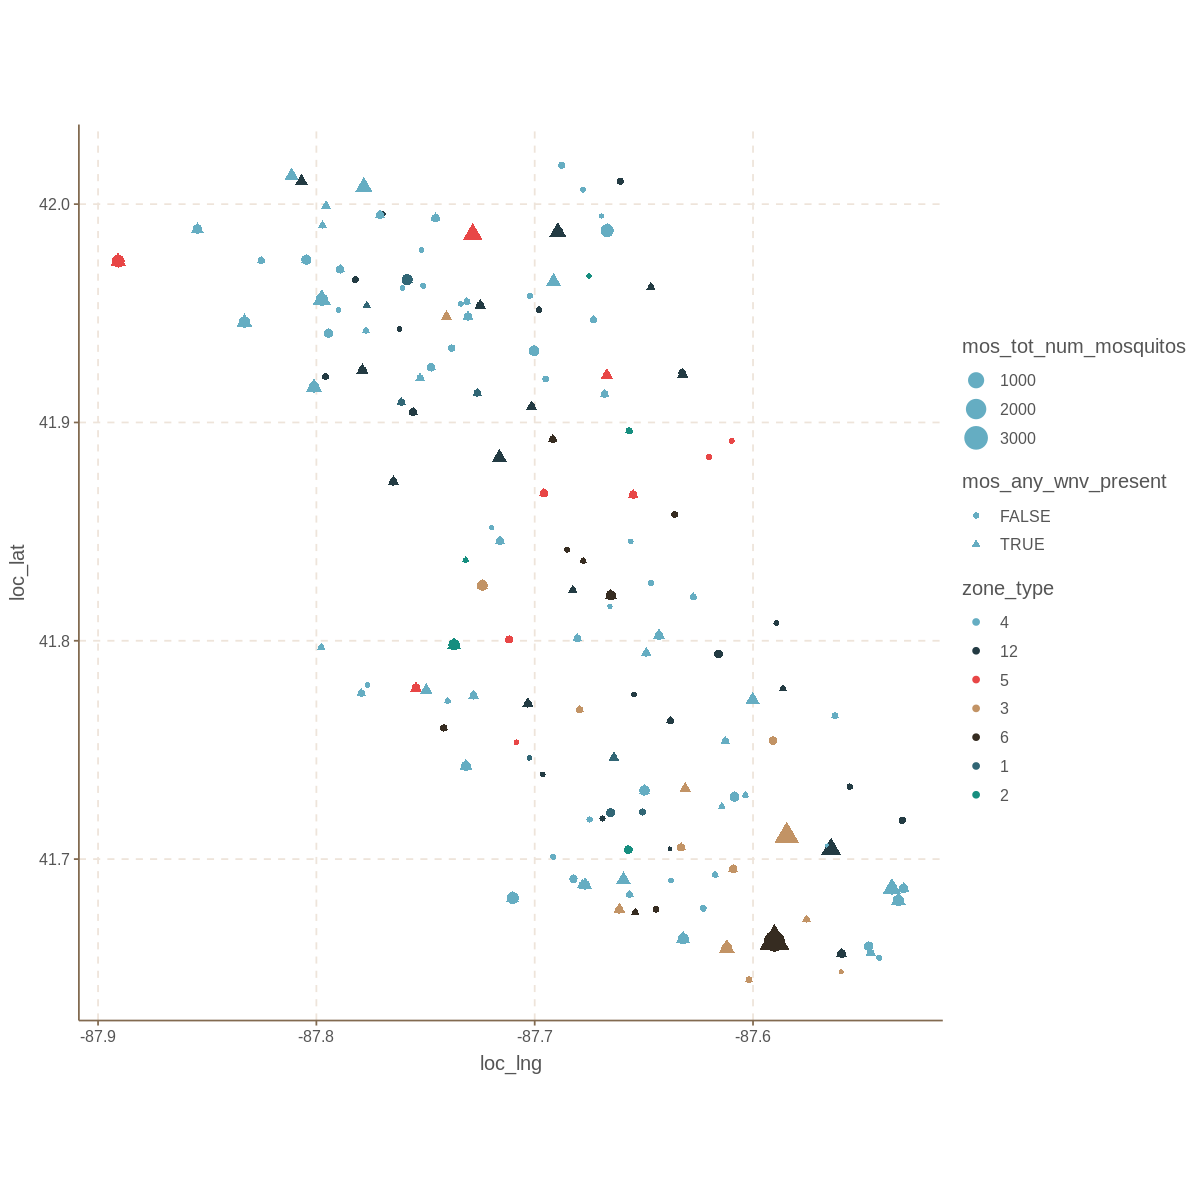

In [45]:
options(repr.plot.width=10, repr.plot.height=10)
df_train %>%
    ggplot(aes(loc_lng,loc_lat,color=zone_type,shape=mos_any_wnv_present,size=mos_tot_num_mosquitos))+
    geom_jitter()+
    coord_equal()